# Prevendo a Magnitude de Tornados nos EUA utilizando Redes Neurais
### Anelise, Gustavo e Matheus

In [5]:
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from optuna import create_study, Trial

from classes import DataModule, MLP, cria_modelo, funcao_objetivo

## Introdução

Neste notebook, optamos por omitir a construção das classes e funções utilizadas, colocando-as no arquivo `classes.py`. Apesar de não apresentarmos diretamente o código, explicamos os processos realizados, desde o tratamento do dataset até a busca pela melhor arquitetura de rede neural para o nosso problema. É importante notar que apesar do problema originalmente ser uma classificação, uma vez que a escala de magnitude para tornados assume apenas os valores inteiros de 0 até 5, optamos por realizar uma regressão, devido ao foco do curso.

## Tratamento do dataset

O dataset em questão, presente no arquivo `tornado.csv`, possuia informações sobre tornados que ocorreram nos Estado Unidos. Os atributos escolhidos para o treino do modelo foram os meses de ocorrência, a latitute e longitude inicial, a distância percorrida e largura do tornado. Os features escolhidos nos trazem informação sobre algumas das condições iniciais que o tornado se encontrava, assim como certas características físicas. Acreditamos que eles apresentam influência sobre a magnitude do tornado, que é o target do problema.

Após a escolha dos features e target, separamos os dados em treino, validação e teste, com 10% dos dados para validação, 10% para teste, e o restante para treino. Em seguida, aplicamos a normalização pelo máximo absoluto em todos os dados, com o cuidado de realizar esta operação após a separação de treino, teste e validação, para não haver vazamento de dados. Todas essas operações estão presentes na classe `DataModule`.

## Arquiteturas de MLP

Em seguida criamos a classe `MLP`, que representa os modelos de rede neural que serão utilizados. A classe precisou ser adaptada para possuir diversas arquiteturas possíveis, variando o número de camadas ocultas, neurônios por camada oculta, funções de ativação e otimizadores. Isso permite com que treinássemos diversas arquiteturas diferentes, escolhendo no final o melhor modelo. O treinamento dos modelos foi feito com o módulo `optuna`. Os parâmetros variados na arquiteuras foram:
- Número de camadas ocultas: de 1 até 3 camadas.
- Número de neurônios por camada oculta: de 3 até 16 neurônios.
- Funções de ativação: ReLU, sigmoide, tangente hiperbólico e Leaky ReLU.
- Otimizadores: Adam, Descida do Gradiente Estocástico e RMSPROP.

Juntamente com esses parâmetros, também incluímos a taxa de aprendizado como um parâmetro dos trials feitos com o `optuna`. Os dados foram passados pelas redes em batches de 256 dados, e os modelos foram treinados por 50 épocas, devido ao número de dados presentes no dataset, em um sistema de computação de alta performance (HPC). O script utilizado para tal tarefa está no GitHub, com o nome de `trabalho_final_optuna_gpu.py`, utilizando o job `job_gpu.sh`.

### Funções de ativação

Aqui mostramos as fórmulas das funções de ativação utilizadas. A sigmoide, $\sigma(x)$, é dada por:
\begin{equation}
\sigma(x) = \frac{1}{1+e^{-x}}
\end{equation}
A tangente hiperbólica, $\tanh(x)$, é dada por:
\begin{equation}
\tanh x = \frac{e^x - e^{-x}}{e^{x}+e^{-x}}
\end{equation}
A ReLU, $\text{ReLU}(x)$ é dada por:
\begin{equation}
\text{ReLU}(x) = \max(0, x)
\end{equation}
Por fim, a Leaky ReLU, $\text{LReLU}(x)$ é dada por:
\begin{equation}
\text{LReLU}(x) = \max(0.1x, x)
\end{equation}

### Otimizadores

#### Descida do Gradiente Estocástico (SGD)

A descida do gradiente estocástico (SGD) atualiza os pesos após processar acada batch de dados. Ou seja, ao invés de atualizar os parâmetros do modelo após uma época, o SGD atualiza os pesos após cada batch, mantendo a mesma forma de atualização da descida do gradiente, utilizando a taxa de aprendizado e se movendo no sentido oposto ao gradiente da função de perda. 

#### RMSPROP e Adam

Os otimizadores RMSPROP e Adam permitem com que a taxa de aprendizado seja atualizada conforme os dados são processados pela rede. Quando o gradiente encontrado é pequeno, a taxa de aprendizado assume um valor maior, passando mais rapidamente por regiões planas. Quando um gradiente grande é encontrado, indicando uma região mais inclinada no hiperplano de parâmetros, a taxa de aprendizado é reduzida de forma a convergir para a região de mínimo [1].

Ambos os algoritmos funcionam de forma similar, sendo que o Adam possui algumas modificações adicionais com relação ao RMSPROP, utilizando análogos de velocidade e momento nas equações de atualização dos valores de pesos da rede. É importante ressaltar que apesar de um algoritmo parecer mais sofisticado que o outro, isso não necessariamente torna ele melhor que um mais simples. No nosso caso, apesar do RMSPROP e Adam possuirem implementações mais complexas que o SGD, isso não necessariamente os torna melhores, e por isso utilizamos os três como possíveis otimizadores da rede [1].

## Treinando o melhor modelo

Por fim, vamos treinar o modelo com a melhor arquitetura encontrada, além de plotar o gráfico da curva de aprendizado durante o período de treinamento. Os melhores parâmetros podem ser vistos no arquivo `slurm-1257.out`, no trial 13. 

In [2]:
treinador = L.Trainer(max_epochs=100)

dm = DataModule()

mlp = MLP(
    num_dados_entrada = 5, 
    num_neuronios = 16, 
    num_camadas = 2, 
    num_targets = 1, 
    ativacao = nn.LeakyReLU(), 
    optimizer = 'rmsprop', 
    lr = 0.004099307037867734
)

treinador.fit(mlp, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | rede | Sequential | 385   
------------------------------------
385       Trainable params
0         Non-trainable params
385       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

c:\venv\ilumpy\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\venv\ilumpy\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


Plotando a curva de aprendizado, com as curvas de treino e validação.

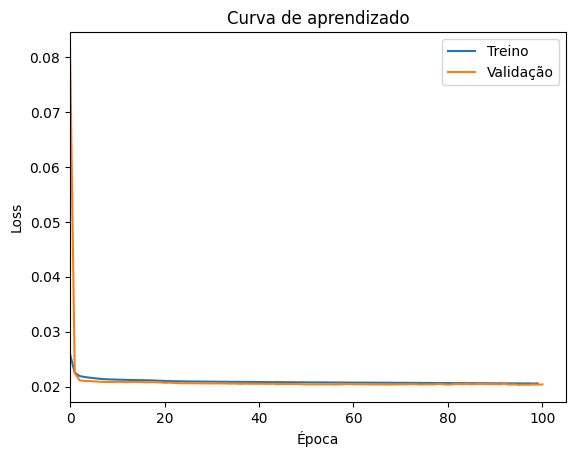

In [3]:
figura, eixo = plt.subplots()

treino = mlp.curva_aprendizado_treino
validacao = mlp.curva_aprendizado_val

eixo.plot(treino, label="Treino")
eixo.plot(validacao, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss");

Por fim, vamos avaliar a performance do modelo.

In [4]:
mlp.eval()

dm.setup("test")

with torch.no_grad():
    X_true = dm.X_teste

    y_true = dm.y_teste
    y_true = dm.y_scaler.inverse_transform(y_true)

    y_pred = mlp(X_true)
    y_pred = dm.y_scaler.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)

    print(f'O RMSE obtido foi de: {RMSE:.3f}')

O RMSE obtido foi de: 0.724


## Resultados e Discussão

Inicialmente, o objetivo do projeto era prever a magnitude de tornados a partir de certas condições inciais e aspectos físico do mesmo. Após o treinamento do melhor modelo, obtemos um RMSE de 0.724. Novamente, é importante ressaltar que apesar de a escala de magnitude ser discreta, caracterizando um problema de classificação, utilizamos um regressor devido ao foco da disciplina. 

Como utilizamos uma rede regressora, obtemos parâmetros de performance relativos a modelos regressores. Dessa forma, o RMSE obtido pode ser interpretado como unidades de magnitude, ou seja, o modelo erra o valor de magnitude de um tornado em 0.724 unidades de magnitude, em média. Apesar do RMSE não ser uma métrica adequada para analisar a performance de problemas de classificação, consideramos que o RMSE obtido foi razoavelmente baixo, uma vez que o valor obtido foi menor que uma unidade de magnitude. Com isso, podemos observar que os features utilizados fornecem informações razoáveis para estimarmos a magnitude de um tornado, apesar da complexidade do sistema estudado.

## Conclusão

Concluímos que o modelo final obteve uma performance razoável, com RMSE igual a 0.724. Em futuros trabalhos, poderíamos utilizar redes classificadoras para obtermos uma melhor análise dos resultados.

## Referências 

[1] Optimization for Deep Learning (Momentum, RMSprop, AdaGrad, Adam). Link: https://www.youtube.com/watch?v=NE88eqLngkg